<a href="https://colab.research.google.com/github/brit228/DS-Unit-2-Sprint-2-Linear-Regression/blob/master/module2-polynomial-regression/Polynomial_Log_linear_Regression_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Linear Regression Practice

## Use a Linear Regression model to get the lowest RMSE possible on the following dataset:

[Dataset Folder](https://github.com/ryanleeallred/datasets/tree/master/Ames%20Housing%20Data)

[Raw CSV](https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv)

## You model must include (at least):
- A log-transformed y variable
- Two polynomial features
- One interaction feature
- 10 other engineered features

What is the lowest Root-Mean-Squared Error that you are able to obtain? Share your best RMSEs in Slack!

Notes:

There may be some data cleaning that you need to do on some features of this dataset. Linear Regression will only accept numeric values and will not accept

Note* There may not be a clear candidate for an interaction term in this dataset. Include one anyway, sometimes it's a good practice for predictive modeling feature engineering in general. 

In [0]:
import pandas as pd
import numpy as np
import random

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

model = LinearRegression()

max_poly = 3
Y_col = "SalePrice"
all_features = []
feature_types = [("Initial", lambda x: x, "{}")]
feature_types += [("X^{}".format(n), lambda x: x**n, "{}"+"**{}".format(n)) for n in range(2,max_poly+1)]

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv", header=0)
for c in df:
  if df[c].dtype == 'object':
    c_df = pd.get_dummies(df[c])
    for v in c_df:
      df["{}:{}".format(c,v)] = c_df[v]
na_col = [x for x in df if df[x].isna().sum() == 0 and df[x].dtype in ["int64", "float64"] and x not in ["Id", Y_col]]

df, df_test = train_test_split(df, test_size=0.5)
Y = np.log(df[Y_col].values.reshape(-1,1))
Y_test = np.log(df_test[Y_col].values.reshape(-1,1))
df = df[na_col]
df_test = df_test[na_col]

for c in df:
  X = df[c].values.reshape(-1,1)
  for v in feature_types:
    X0 = v[1](X)
    model.fit(X0, Y)
    r2 = r2_score(Y, model.predict(X))
    all_features.append((r2, v[2].format("df['{}'].values".format(c))))

In [0]:
X = np.zeros((df.shape[0], 2))
for i in range(len(list(df)[::-1])):
  X = df[list(df)[i]].values
  for j in range(i, len(list(df))):
    X0 = X * df[list(df)[j]].values
    X0 = X0.reshape(-1,1)
    model.fit(X0, Y)
    r2 = r2_score(Y, model.predict(X0))
    all_features.append((r2, "df['{}'].values*df['{}'].values".format(list(df)[::-1][i],list(df)[j])))

In [0]:
from sklearn.cluster import KMeans

max_clusters = 10
for c in df:
  X = df[c].values.reshape(-1,1)
  kmeans = KMeans(n_clusters=2, random_state=0)
  kmeans.fit(X)
  p = kmeans.predict(X).reshape(-1,1)
  model.fit(p, Y)
  r2 = r2_score(Y, model.predict(p))
  all_features.append((r2, "KMeans(n_clusters=2, random_state=0).fit(df['{}'].values.reshape(-1,1)).predict(df['{}'].values.reshape(-1,1))".format(c,c)))

In [4]:
import matplotlib.pyplot as plt

def getR2(v):
  return v[0]

sort_features = sorted(all_features, key=getR2)
X = eval(sort_features[0][1]).reshape(-1,1)
X_test = eval(sort_features[0][1].replace("df", "df_test")).reshape(-1,1)
model.fit(X,Y)
RMSE_out = [float(np.sqrt(mean_squared_error(Y, model.predict(X))))]
R2_out = [float(r2_score(Y, model.predict(X)))]
print("{:150s}\t{:>16s}\t{:>16s}\t{:>16s}".format("ADDITION", "RMSE", "R^2", "R^2 Test"))
print("{:150s}\t{: 16.4f}\t{: 16.8f}\t{: 16.8f}".format(sort_features[-1][1], RMSE_out[-1], R2_out[-1], float(r2_score(Y_test, model.predict(X_test)))))
used = [all_features.index(sort_features[-1])]
num = 20
for i in range(num-1):
  R2_l = []
  shape = X.shape
  for j in range(len(all_features)):
    if j not in used:
      X0 = X
      X0 = np.append(X0, eval(all_features[j][1]).reshape(-1,1), axis=1)
      model.fit(X0,Y)
      R2_l.append(float(r2_score(Y, model.predict(X0))))
    else:
      R2_l.append(R2_out[-1])
  ind = R2_l.index(max(R2_l))
  X = np.append(X, eval(all_features[ind][1]).reshape(-1,1), axis=1)
  X_test = np.append(X_test, eval(all_features[ind][1].replace("df", "df_test")).reshape(-1,1), axis=1)
  model.fit(X,Y)
  RMSE_out.append(float(np.sqrt(mean_squared_error(Y, model.predict(X)))))
  R2_out.append(float(r2_score(Y, model.predict(X))))
  R2_test = float(r2_score(Y_test, model.predict(X_test)))
  print("{:150s}\t{: 16.4f}\t{: 16.8f}\t{: 16.8f}".format(all_features[ind][1], RMSE_out[-1], R2_out[-1], R2_test))
  used.append(ind)
print()
print()
print("{:150s}\t{: 16.4f}\t{: 16.8f}".format("Model Test Values:", float(np.sqrt(mean_squared_error(Y_test, model.predict(X_test)))), float(r2_score(Y_test, model.predict(X_test)))))

ADDITION                                                                                                                                              	            RMSE	             R^2	        R^2 Test
df['MiscVal'].values*df['YearBuilt'].values                                                                                                           	          0.3333	      0.31418569	      0.32416162
df['GarageCars'].values*df['GrLivArea'].values                                                                                                        	          0.2215	      0.69715822	      0.68528384
df['OverallQual'].values                                                                                                                              	          0.1929	      0.77020297	      0.78628571
KMeans(n_clusters=2, random_state=0).fit(df['BsmtFinSF1'].values.reshape(-1,1)).predict(df['BsmtFinSF1'].values.reshape(-1,1))                        	          0.1850	      0.78872455	      0

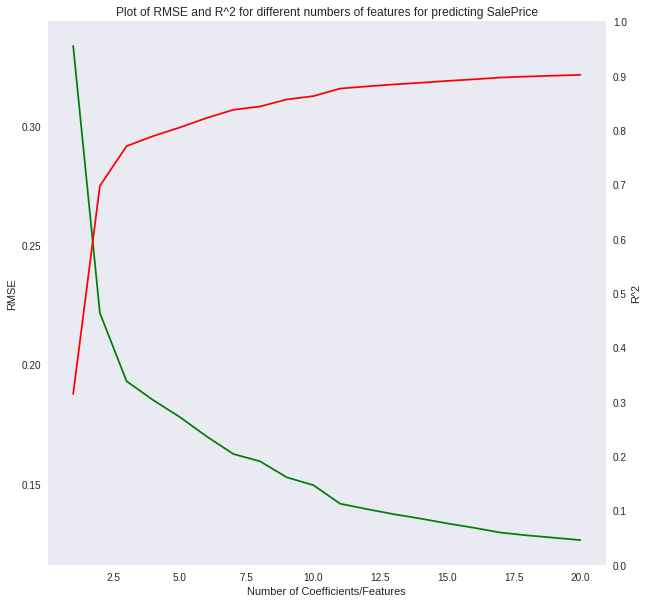

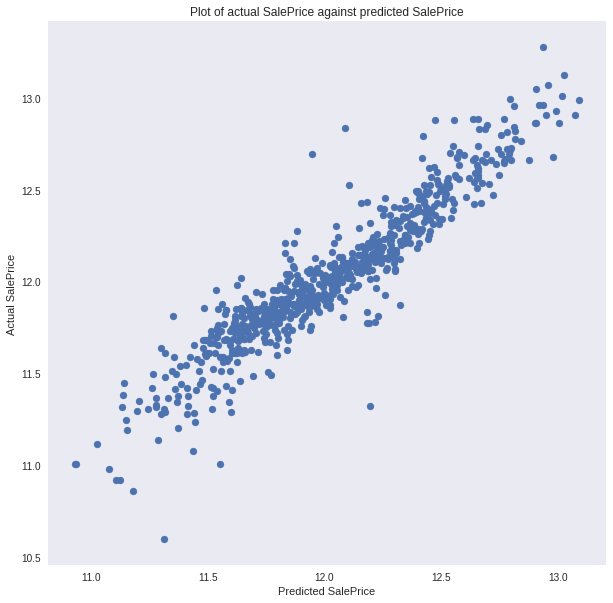

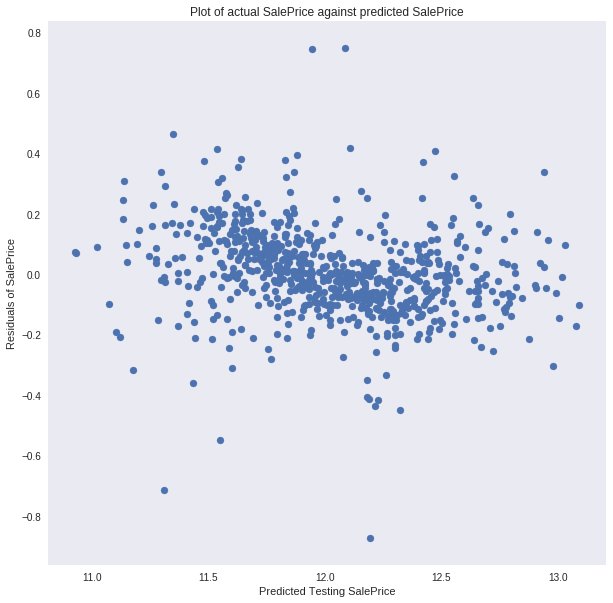

In [5]:
fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(111)
ax.set_xlabel("Number of Coefficients/Features")
ax.plot([x for x in range(1, num+1)], RMSE_out, color='green')
ax.set_ylabel("RMSE")
ax2 = ax.twinx()
ax2.plot([x for x in range(1, num+1)], R2_out, color='red')
ax2.set_ylabel("R^2")
ax2.set_ylim([0.0,1.0])
ax2.set_yticks([x/10 for x in range(0,11)])
ax.set_title("Plot of RMSE and R^2 for different numbers of features for predicting {}".format(Y_col))
ax.grid(False)
ax2.grid(False)


fig2 = plt.figure(figsize=(10,10))
bx = fig2.add_subplot(111)
bx.scatter(model.predict(X_test), Y_test)
bx.set_xlabel("Predicted {}".format(Y_col))
bx.set_ylabel("Actual {}".format(Y_col))
bx.set_title("Plot of actual {} against predicted {}".format(Y_col, Y_col))
bx.grid(False)

fig3 = plt.figure(figsize=(10,10))
cx = fig3.add_subplot(111)
cx.scatter(model.predict(X_test), Y_test - model.predict(X_test))
cx.set_xlabel("Predicted Testing {}".format(Y_col))
cx.set_ylabel("Residuals of {}".format(Y_col))
cx.set_title("Plot of actual {} against predicted {}".format(Y_col, Y_col))
cx.grid(False)

plt.show()

In [8]:
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js?config=TeX-MML-AM_CHTML'></script>"))
s = "{:.8f}".format(float(model.intercept_))
out = r'$$\begin{{eqnarray}} \log ({}) & = & {}{:.12f} \\'.format(Y_col, r"\;\:" * (16 - len(s)), float(model.intercept_))
for i in range(len(used)):
  t = all_features[used[i]][1]
  t_l = t.split("'")
  t_e = t.split("**")
  out_l = []
  for j in range((len(t_l) - 1)//2):
    out_l.append(t_l[2*j+1])
  coef = float(model.coef_[0][i])
  if coef < 0:
    s = "{:.8f}".format(-coef)
    out += " & - & {}{:.12f} ".format(r"\;\:" * (16 - len(s)), -coef)+" \cdot "
  else:
    s = "{:.8f}".format(coef)
    out += " & + & {}{:.12f} ".format(r"\;\:" * (16 - len(s)), coef)+" \cdot "
  if t.split("(")[0] == "KMeans":
    out += "KMeans({})".format(out_l[0])
  elif len(out_l) > 1:
    out += " \cdot ".join(out_l)
  else:
    out += out_l[0]
  if len(t_e) > 1:
    out += "^{}".format(t_e[-1])
  out += r" \\ "
out += r"\end{eqnarray}$$"
Math(r'{}'.format(out))

<IPython.core.display.Math object>

# Stretch Goals

- Write a blog post explaining one of today's topics.
- Find a new regression dataset from the UCI machine learning repository and use it to test out your new modeling skillz.
 [ - UCI Machine Learning Repository - Regression Datasets](https://)
- Make a list for yourself of common feature engineering techniques. Browse Kaggle kernels to learn more methods.
- Start studying for tomorrow's topic: Gradient Descent
- Try and make the ultimate model with this dataset. clean as many features as possible, engineer the most sensible features as possible and see how accurate of a prediction you can make. 
- Learn about the "Dummy Variable Trap" and how it applies to linear regression modeling.
- Learning about using linear regression to model time series data